In [1]:
from datetime import datetime
from glob import glob
import json
import os

import cv2
from keras import losses, Model, optimizers, metrics
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, DepthwiseConv2D, Dropout, Flatten, Input, Reshape
from keras.losses import SparseCategoricalCrossentropy
# from keras.metrics import MeanSquaredError, SparseCategoricalAccuracy
from keras.utils import plot_model
from livelossplot import PlotLossesKeras, PlotLossesKerasTF
from matplotlib import pyplot as plt
from numpy import interp
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.python.ops.image_ops_impl import *

from helper.dataset_mkr import *
from helper.eval_function import *
from helper.gpu_memory import *
from helper.model import *
from helper.model_visualizer import *

2022-10-28 01:25:58.063825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 01:25:58.187376: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 01:25:58.755488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/z/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-28 01:25:58.755614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [2]:
# load tensorboard
%load_ext tensorboard


In [3]:
"""
0 CPU
1 필요한 만큼 메모리를 런타임에 할당
2 GPU에 할당되는 전체 메모리 크기를 제한
"""
set_gpu_memory(1)

1 Physical GPUs, 1 Logical GPUs


2022-10-28 01:26:00.108317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 01:26:00.112781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 01:26:00.113028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 01:26:00.113630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
MIN, MAX = 0, 255

CLASS = 23
# RAW_CLASS = 23
# CLASS = RAW_CLASS+1  ## 1: BACKGROUND


# 1. DATASET

In [5]:
data_dir = f"/media/z/0/MVPC10/DATA/v1.1/RAW/03"
# file = f"label_1248_cnt.csv"
file = f"~/LABELING/v2.1_FINAL_REFINED.csv"
df = pd.read_csv(file)
# df.sort_values(by=df.keys()[0], inplace=True, ascending=True)
print(df)


                path                                              label
0      1650315736806                                     [[0, 0, 0, 0]]
1      1650315796123                                     [[0, 0, 0, 0]]
2      1650315856514                                     [[0, 0, 0, 0]]
3      1650315917006                                     [[0, 0, 0, 0]]
4      1650315976418                                     [[0, 0, 0, 0]]
...              ...                                                ...
86493  1661954116964  [[25, 41, 40, 67], [38, 32, 50, 60], [54, 43, ...
86494  1661954176336                                     [[0, 0, 0, 0]]
86495  1661954236769                                     [[0, 0, 0, 0]]
86496  1661954296445                [[15, 19, 31, 40], [26, 7, 33, 23]]
86497  1661954356730                                 [[13, 18, 31, 37]]

[86498 rows x 2 columns]


In [6]:
df.empty

False

In [7]:
df.values[:,1].dtype

dtype('O')

In [8]:
df1 = v2_1_data_mkr(df, z_value=2)
df1.head

<bound method NDFrame.head of                 path  label
0      1650315796123      0
1      1650315917006      0
2      1650316036754      0
3      1650316156301      0
4      1650316276225      0
...              ...    ...
67461  1661954056432      9
67462  1661954116964      4
67463  1661954236769      0
67464  1661954296445      2
67465  1661954356730      1

[67466 rows x 2 columns]>

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

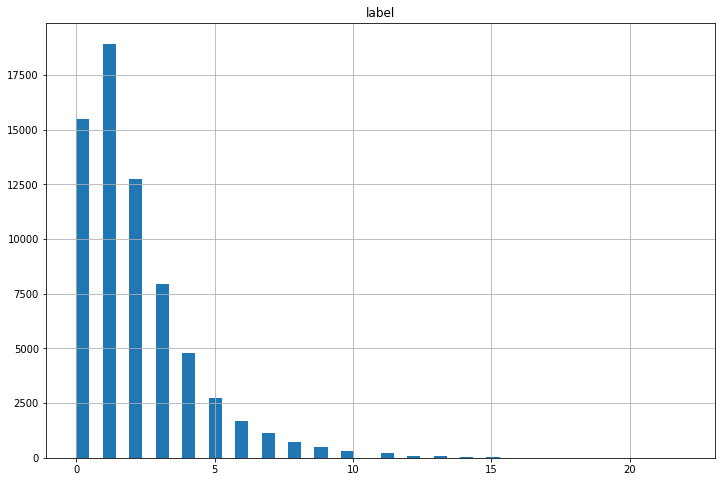

In [9]:
df1.hist(column="label", bins=CLASS*2, figsize=(12, 8))

In [10]:
df1['label'].value_counts().describe()

count       20.000000
mean      3373.300000
std       5772.821449
min          1.000000
25%         30.250000
50%        404.500000
75%       3258.250000
max      18938.000000
Name: label, dtype: float64

In [11]:
# df1.to_csv(f"test.csv", index=False)

### 1.2 AUGMENT

In [12]:
# ---------------------------------------------------------------- SHUFFLE DATA
SHUFFLE_DATA = 1
if SHUFFLE_DATA == 1:
    df1 = df1.sample(frac=1).reset_index(drop=True)
# df

In [13]:
## DROP ERROR
# df1 = df[df.iloc[:, 1] > 0]
# df1.head

### 1.4 DATA to TENSOR

In [14]:
data_full_path = f"/media/z/0/MVPC10/CODE/pplcnt_model/labeling_tool/out"

data, label = df_to_tensor(df1, data_full_path)

0
10000
20000
30000
40000
50000
60000


In [15]:
data = np.array(data)
data = data.reshape(data.shape[0], 80, 80, 1)
print(data.shape)

label = np.array(label)
label = label.reshape(label.shape[0], 1, 1, 1)
print(label.shape)

H, W = data.shape[1], data.shape[2]
print(H, W)


(67466, 80, 80, 1)
(67466, 1, 1, 1)
80 80


In [16]:
np.unique(label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 21, 22])

### 1.5 PROCESS

In [17]:
# set(data.reshape(-1))

In [18]:
## ---------------------------------------------------------------- SHUFFLE
# seed = 99
# np.random.seed(seed)
# np.random.shuffle(data)
# # np.random.seed(seed)
# np.random.shuffle(label)

## ---------------------------------------------------------------- LABEL NORMALIZE
# norm_label = label/CLASS
norm_label = label  ## NO NORMALIZE
# norm_label.dtype

## ---------------------------------------------------------------- DATA NORMALIZE
# print(data[0][0])
norm_data = data/MAX
# norm_data = data.astype("float")/MAX
# print(norm_data[0][0])


## ---------------------------------------------------------------- SPLIT
split1 = int(len(label)*0.96)
X1, X2 = norm_data[:split1], norm_data[split1:]
Y1, Y2 = norm_label[:split1], norm_label[split1:]
## VAL SPLIT
split2 = int(len(label)*0.9)
# X1, val_data = X1[:split2], X1[split2:]
# X2, val_label = X2[:split2], X2[split2:]



In [19]:
print(X1.shape)
print(Y1.shape)
print(X2.shape)
print(Y2.shape)

(64767, 80, 80, 1)
(64767, 1, 1, 1)
(2699, 80, 80, 1)
(2699, 1, 1, 1)


# 2. TRAIN

In [20]:
LOAD_MODEL = 1
MODEL_VERSION = f"v2.1"

if LOAD_MODEL == 0:
    ## ---------------------------------------------------------------- SETUP
    inc = make_inc()
    # size = input_shape - layer_shape + 1
    ## con(filter, (size), stride, padding, activation, name, input)

    ## ---------------------------------------------------------------- IN
    input = Input(shape=(H, W, 1))

    ## ---------------------------------------------------------------- HEAD
    x = con(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', input)

    ## ---------------------------------------------------------------- BODY
    x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 5, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 11, 2, 'valid', 'elu', 0.25, f'{inc()}', x)


    ## ---------------------------------------------------------------- TAIL
    x = Conv2D(1, 15, strides=2, name=f'{inc()}')(x)
    # x = tf.reduce_mean(x, (1, 2))  #, axis=None, keepdims=False, name=None)
    # x = Dropout(.5)(x)

    ## ---------------------------------------------------------------- OUT
    output = Conv2D(1, x.shape[1], strides=4, name=f'{inc()}')(x)

    ## ---------------------------------------------------------------- FINAL
    model = Model(input, output)

    ## ---------------------------------------------------------------- OPTIMIZER
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #         initial_learning_rate=0.001,
    #         decay_steps=100000,
    #         decay_rate=0.96,
    #         staircase=True)

    # lr_schedule = k.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4,
    #                                                  decay_steps=EPOCH,
    #                                                  )

    # optimizer = optimizers.Adam(learning_rate=lr_schedule)
    optimizer = optimizers.Adam(learning_rate=0.0001)

    ## ---------------------------------------------------------------- LOSS
    # def adaptive_loss():
    #     pass
    # loss = losses.MeanAbsoluteError()
    # loss = losses.BinaryCrossentropy()
    loss = losses.MeanSquaredError()
    # loss = losses.SparseCategoricalCrossentropy()
    # loss = losses.BinaryFocalCrossentropy(  #apply_class_balancing=False,
    # alpha=0.25,
    # gamma=2.0,
    # from_logits=False,
    # label_smoothing=0.0,
    # axis=-1,
    # reduction=losses_utils.ReductionV2.AUTO,
    # name='binary_focal_crossentropy'
    # )

    ## ---------------------------------------------------------------- METRICS
    # metrics = ['accuracy']
    # metrics = [SparseCategoricalAccuracy]
    # metrics = [metrics.MeanSquaredError()]

    ## ---------------------------------------------------------------- COMPILE
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


elif LOAD_MODEL == 1:
    model_path_last = glob(f"OUT/{MODEL_VERSION}/model/*.h5")[-1]
    model_path = f"OUT/{MODEL_VERSION}/model/20221024-191637.h5"
    model = tf.keras.models.load_model(model_path_last)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 1_C2 (Conv2D)               (None, 68, 68, 64)        10880     
                                                                 
 1_BN (BatchNormalization)   (None, 68, 68, 64)        256       
                                                                 
 1_ACT (Activation)          (None, 68, 68, 64)        0         
                                                                 
 1_DO (Dropout)              (None, 68, 68, 64)        0         
                                                                 
 2_C2 (Conv2D)               (None, 58, 58, 64)        495680    
                                                                 
 2_0_BN (BatchNormalization)  (None, 58, 58, 64)       256   

In [28]:
# weight_visualizer(model, 0, -1)

# filter_visualizer(model, X2[2])

In [104]:
conv_layers1 = []
for i in model.layers:
    if 'C2' in i.output:
        print()
        # conv_layers1.append(i.output)
conv_layers1


TypeError: argument of type 'KerasTensor' is not iterable

In [80]:
a = model.get_layer('8_C2').output
a

<KerasTensor: shape=(None, 34, 34, 64) dtype=float32 (created by layer '8_C2')>

In [114]:
conv_layer_index = [1, 5, 9, 13]
conv_layers = [model.layers[i].output for i in conv_layer_index]
# conv_layers = [i.output for i in model.layers if "C2" in i.name][:1]
print(conv_layers)

[<KerasTensor: shape=(None, 68, 68, 64) dtype=float32 (created by layer '1_C2')>, <KerasTensor: shape=(None, 58, 58, 64) dtype=float32 (created by layer '2_C2')>, <KerasTensor: shape=(None, 58, 58, 64) dtype=float32 (created by layer '2_1_C2')>, <KerasTensor: shape=(None, 50, 50, 64) dtype=float32 (created by layer '3_C2')>]


In [116]:
visualize_model = Model(model.inputs, conv_layers)
print(visualize_model.summary())

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 1_C2 (Conv2D)               (None, 68, 68, 64)        10880     
                                                                 
 1_BN (BatchNormalization)   (None, 68, 68, 64)        256       
                                                                 
 1_ACT (Activation)          (None, 68, 68, 64)        0         
                                                                 
 1_DO (Dropout)              (None, 68, 68, 64)        0         
                                                                 
 2_C2 (Conv2D)               (None, 58, 58, 64)        495680    
                                                                 
 2_0_BN (BatchNormalization)  (None, 58, 58, 64)       256

1/1 [==============================] - 0s 27ms/step


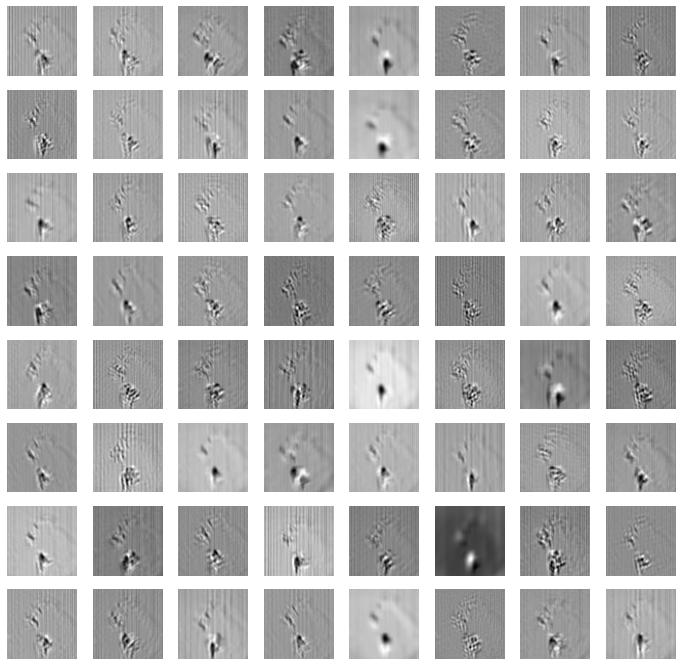

1/1 [==============================] - 0s 12ms/step


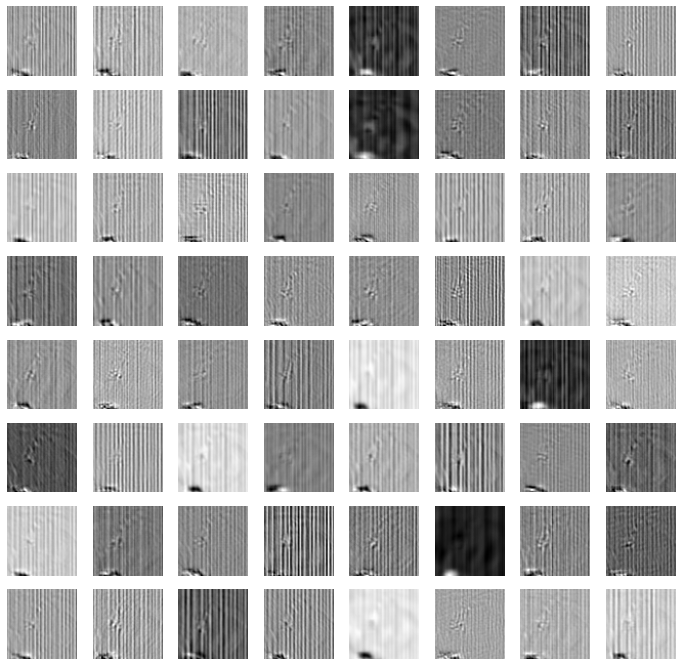

1/1 [==============================] - 0s 12ms/step


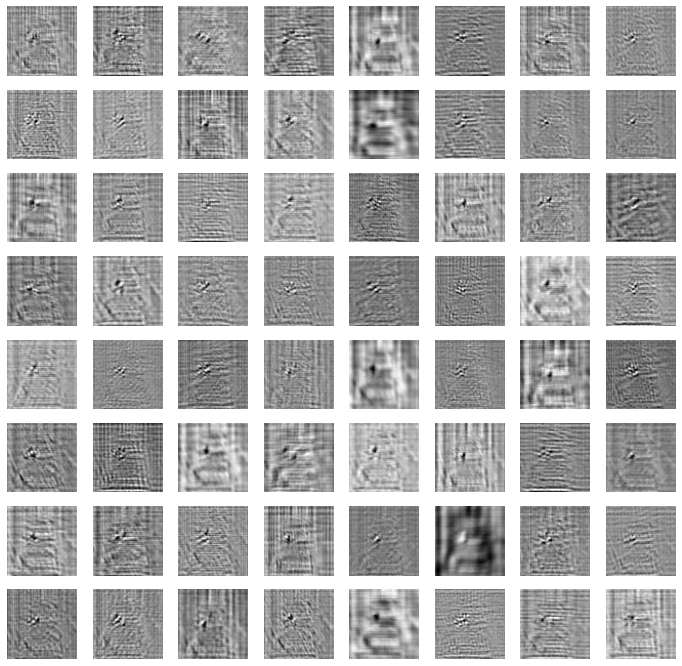

1/1 [==============================] - 0s 16ms/step


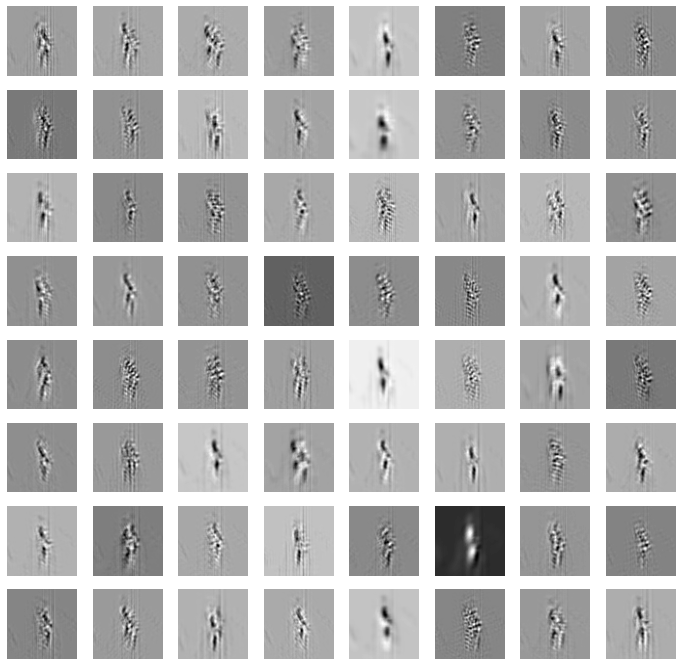

1/1 [==============================] - 0s 12ms/step


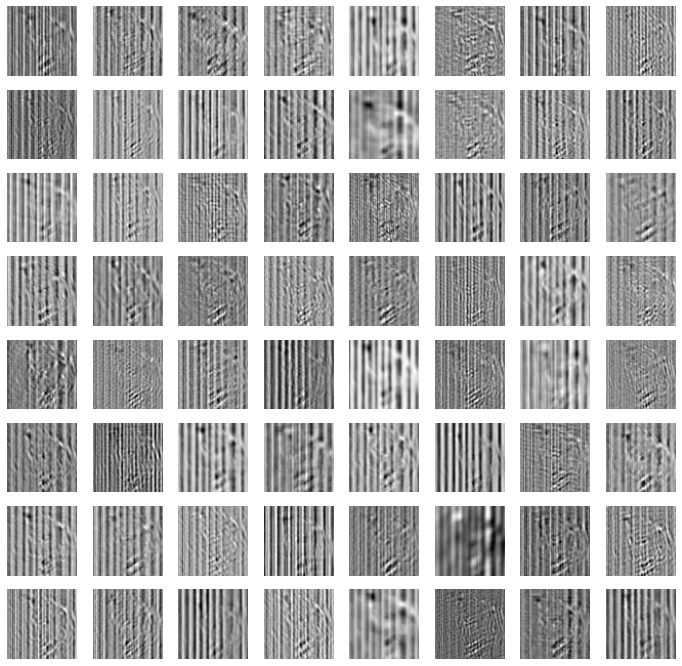

1/1 [==============================] - 0s 13ms/step


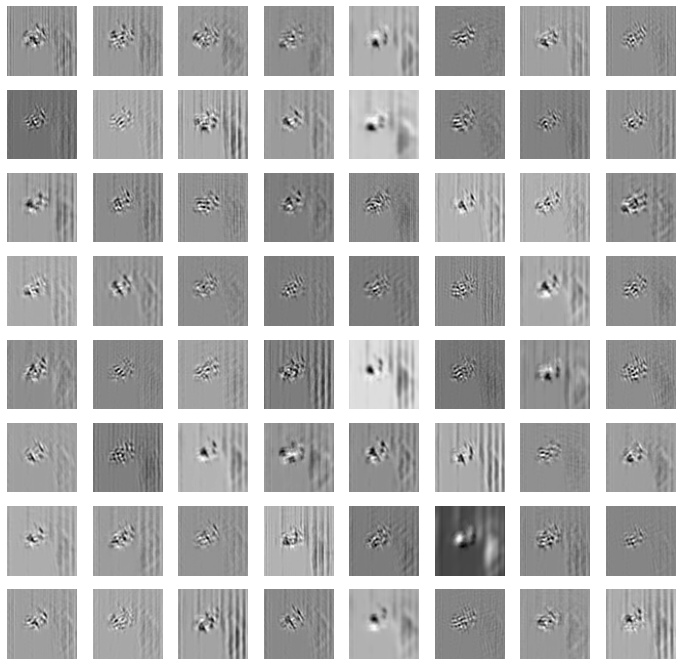

1/1 [==============================] - 0s 12ms/step


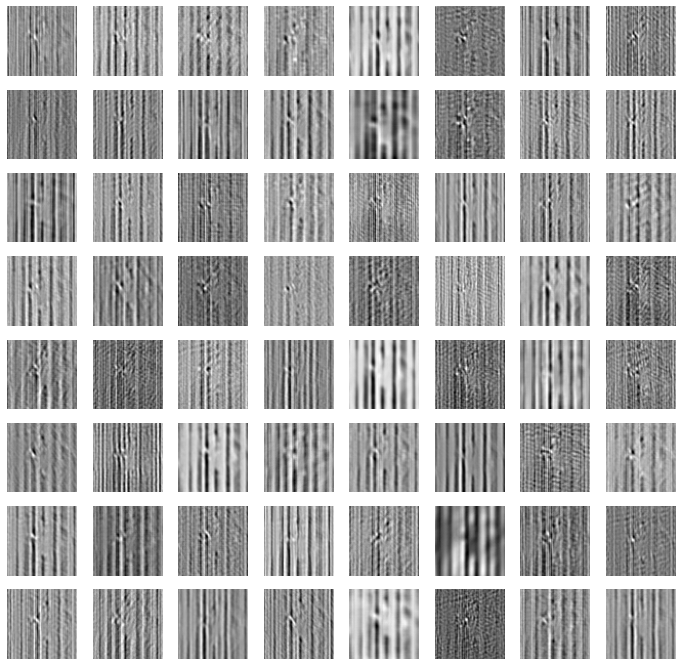

1/1 [==============================] - 0s 12ms/step


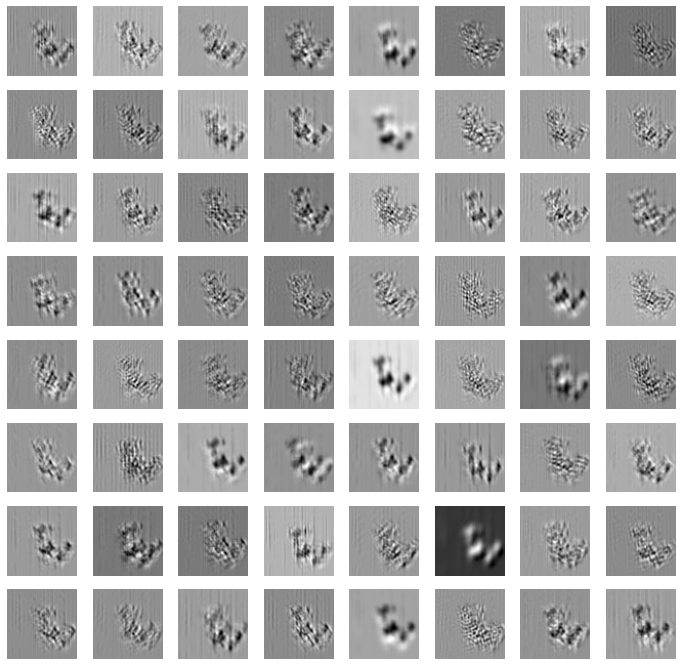

In [89]:
for i in range(20, 100, 10):
    img = X2[i]
    re_img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    conv_img = visualize_model.predict(re_img)
    # columns = int(round(np.sqrt(model.shape[1])))
    # rows = int(round(np.sqrt(model.shape[2])))
    columns = 8
    rows = 8
    for c_img in conv_img:
        # pos = 1
        fig = plt.figure(figsize=(12, 12))
        for i in range(1, columns*rows+1):
            fig = plt.subplot(rows, columns, i)
            fig.axis('off')
            plt.imshow(c_img[:, :, i-1], cmap='gray')
            # pos += 1
        plt.show()

In [ ]:
filter_visualizer(model, data[0])

In [ ]:
# visual_keras(model, MODEL_VERSION)
model_visualizer(model, data[0])

In [ ]:
EPOCH = 16
BATCH = 32
# ES = 16
ES = EPOCH//2

## fit
log_path = f"OUT/{MODEL_VERSION}/logs/"+datetime.now().strftime("%Y%m%d-%H%M%S")
es = EarlyStopping(monitor="val_loss", patience=ES, verbose=2, mode='auto')
tensorboard_callback = TensorBoard(log_dir=log_path, histogram_freq=1)

history = model.fit(X1, Y1,
                    validation_split=0.1,
                    # validation_data=(val_data, val_label),
                    batch_size=BATCH,
                    epochs=EPOCH,
                    use_multiprocessing=True,
                    verbose=1,
                    callbacks=[es,
                               tensorboard_callback,
                               PlotLossesKeras(),
                               # PlotLossesKerasTF(),
                               ],
                    )

# 3. EVALUATE

In [ ]:
SAVE_MODEL = 1
if SAVE_MODEL == 1:
    model_save_name = f"OUT/{MODEL_VERSION}/model/{datetime.now().strftime('%Y%m%d-%H%M%S')}.h5"
    model.save(model_save_name)

In [ ]:
# TENSORBOARD == 1
# if TENSORBOARD == 1:
#     launch tensorboard @ localhost:6006
#     %tensorboard --logdir logs/--host localhost --port 6006
# %tensorboard --logdir={log_path}

In [ ]:
## history to DF
hdf = pd.DataFrame(history.history)
hdf.keys()

## plot history
hdf.plot(figsize=(9, 6), grid=1, xlabel="epoch", label="accuracy")
plt.ylim([0, 2])
plt.show()


In [ ]:
SAVE_MODEL_PLOT = 0
if SAVE_MODEL_PLOT == 1:
    plot_model(model, to_file=f"OUT/{MODEL_VERSION}/plot/{MODEL_VERSION}_modelplot.png", show_shapes=True, show_layer_names=False, show_layer_activations=True)


In [ ]:
loss, acc = model.evaluate(X2, Y2, verbose=1)

predict = model.predict(X2)


In [ ]:
## ---------------------------------------------------------------- OUPUT CONVERT
predict_0 = np.reshape(predict, predict.shape[0])
Y2_0 = np.reshape(Y2, Y2.shape[0])
print(predict_0.shape)
print(Y2_0.shape)

### 3.1 BIAS FINDER

In [ ]:
n = len(predict_0)
F = 0
pp_li = []
for pp in np.arange(-0.0300, 0.1900, 0.01):
    predict1 = predict_0+pp
    for i in range(n):
        diff = abs(predict1[i].round(0).astype(int)-Y2_0[i])
        F += diff
    pp_li.append((pp,F))
    F = 0

for i in pp_li:
    print(i)

### 3.2 ACCURACY

In [ ]:
BIAS = 0.00
predict_1 = predict_0 + BIAS
n = len(predict)
wrong = 0
Y2_cnt = 0
# F_list = []
for i in range(n):
    Y2_cnt += Y2_0[i]
    diff = abs(predict_1[i].round(0).astype(int)-Y2_0[i])
    wrong += diff
    # F_list.append(diff[0])
print(f"error: {wrong}")
print(f"total: {Y2_cnt}")
print(f"acc:   {round((Y2_cnt-wrong)/Y2_cnt, 2)*100}%")


### 3.3 VISUALIZE

In [ ]:
n = 20
for i in range(0, n, 1):
    # if Y2[i][0] > 0.3:
    diff = abs(predict_1[i].round(0).astype(int)-Y2_0[i])
    size = 10
    test_img = Image.fromarray((X2[i]*255).reshape(H,W)).convert('L').resize((W*size, H*size))
    print(f"pred: {predict_1[i]}")
    print(f"labl: {Y2_0[i]}")
    print(f"diff: {diff}")
    # print(f"diff: {X2[i]}")
    display(test_img)


In [ ]:
# BATCH = 32
# EPOCH = 30
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
# for ind in range(len(lb)):
#     # ind는 label 인덱스
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# x_data = []
# y_data = []
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data).astype(np.float32)
# y_data = np.array(y_data).astype(np.float32)
# X1 = X1.astype(np.float32)
# X2 = X2.astype(np.float32)
#
# for i in range(30):
#     print(i)
#     history = model.fit(X1, X2,
#                         # validation_split=0.2,
#                         validation_data=(x_data, y_data),
#                         batch_size=BATCH,
#                         epochs=EPOCH,
#                         verbose=1,
#                         # callbacks=[es],)
#                         # callbacks=[es, tensorboard_callback], )
#                         )
#     model.save('asdf/' + str(i) + '.h5')

In [ ]:
# epo = 10
# model = tf.keras.models.load_model('asdf/' + str(epo) + '.h5')
# Y2.shape
#
# lb = Y2.reshape(-1)
# has = {}
#
# # np.array(list(set(Y2.reshape(-1)))).astype(np.int64)
#
#
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
#
# for ind in range(len(lb)):
#
#     # ind는 label 인덱스
#
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# ls_num
#
# x_data = []
# y_data = []
#
#
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(Y1[ind])
#         y_data.append(Y2[ind])
#
# x_data = np.array(x_data)
# y_data = np.array(y_data)
# x_data.shape
# y_data.shape
#
#
# result = np.argmax(model.predict(x_data), -1)
# cont = 0
# for ind in range(len(result)):
#     if result[ind] == y_data.reshape(-1)[ind]:
#         cont +=1
#
#
# cont
# print(len(ls_num))
# print(cont/len(result))
